In [2]:
import sys
import os
import argparse
import csv
import functools
import pandas
from collections import defaultdict
import rpy2.robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import numpy
import collections

pandas2ri.activate()

In [3]:
def generate_plot(dataframe, jpeg):

    r = rpy2.robjects.r  # Start the R thread
    base = importr("base")
    
    graphics = importr('graphics')

    gplots = importr("gplots")
    color_brewer = importr("RColorBrewer")
    ggplot2 = importr("ggplot2")
    grdevices = importr("grDevices")

    dataframe = dataframe.sort_values(by=["tpm"], ascending=False)
    
    greater_100 = len(dataframe[(dataframe.tpm > 100)].tid)
    hundred_to_ten = len(dataframe[(dataframe.tpm <= 100) & (dataframe.tpm > 10)].tid)
    ten_to_one = len(dataframe[(dataframe.tpm > 1) & (dataframe.tpm <= 10)].tid)
    zer_to_one = len(dataframe[(dataframe.tpm > 0.01) & (dataframe.tpm <= 1)].tid)
    lowest = len(dataframe[(dataframe.tpm <= 0.01)].tid)
    # dataframe = dataframe.transpose()
    
    data_matrix = base.data_matrix(dataframe[dataframe.columns[2:]])
    data_matrix.colnames = rpy2.robjects.vectors.StrVector(dataframe.columns[2:])
    tiff = grdevices.tiff(jpeg, width=40, height=40, units="cm", res=600)
    
    colors = rpy2.robjects.vectors.StrVector(["white", "lightblue", "green", "black", "red"])

    # Create a vector of colour name strings
    rowSide = rpy2.robjects.vectors.StrVector(["gray"]*greater_100 + ["violet"]*hundred_to_ten +
                                              ["sky blue"]*ten_to_one +
                                              ["light green"]*zer_to_one +
                                              ["yellow"]*lowest)
    r.par(mai=rpy2.robjects.vectors.FloatVector([0, 0, 0, 0]))
    gplots.heatmap_2(data_matrix, RowSideColors=rowSide,
                     density_info="none",
                     trace="none",
                     margins=rpy2.robjects.vectors.IntVector([18,15]),
                     col=colors,
                     breaks=numpy.arange(0.5, 6.5),
                     cexCol=2, cexMain=10,
                     par=r.par(cex_main=10),
                     cex_axis=1, cex_main=5, cex_lab=3, cex_sub=3,
                     col_axis="red", col_lab="red",
                     dendogram="none", key=False,
                     Rowv="NA", Colv="NA")

    r.legend("top", fill=colors,
             legend=rpy2.robjects.vectors.StrVector(["1.No Overlap", "2.Generic Overlap (j,m, ..)",
                                                     "3.Fragment (c, e, i, x, p)", "4 Fusion",
                                                     "5.Complete match of intron chain (=)"]),
             cex=1.8,
             title="Class code legend")

    r.legend("left",
             legend = rpy2.robjects.vectors.StrVector([">100 TPM", "10-100 TPM",
                                                       "1-10 TPM", "0.01-1 TPM", "upto 0.01 TPM"]),
             col = rpy2.robjects.vectors.StrVector(["gray", "violet",
                                                    "sky blue", "light green", "yellow"]),
             cex=1.8,
             lty=1, lwd=10, title="TPM")

    grdevices.dev_off()

In [6]:
def analyse_refmap(input_file, label, values):
    """
    Quick snippet to retrieve the ccodes from the RefMap
    :param input_file:
    :param label:
    :param values:
    :return:
    """

    with open(input_file) as refmap:
        ids_not_found = set()
        for row in csv.DictReader(refmap, delimiter="\t"):
            ccode = row["ccode"]
            # Fusions
            if ccode[0] == "f" and ("=" not in ccode and "_" not in ccode):
                ccode = 4
            # Missing
            elif ccode == "NA":
                ccode = 1
            # Fragments
            elif ccode in ("c", "e", "i", "I", "x", "X", "p", "P"):
                ccode = 3
            # Reconstructed
            elif "_" in ccode or "=" in ccode:
                ccode = 5
            # AS?
            else:
                ccode = 2
            if row["ref_id"] not in values:
                ids_not_found.add(row["ref_id"])
                continue
            values[row["ref_id"]][label] = ccode

        if len(ids_not_found) > 0:
            print("# of ids not found for {0}: {1}".format(
                input_file, len(ids_not_found)),
                  file=sys.stderr
            )

    return values

In [7]:
quant_file = "/usr/users/ga002/venturil/HPC_group-ga/Projects/Mikado/Arabidopsis/Alignments/Kallisto/Original/out_quant/abundance.tsv"

values = collections.defaultdict(dict)
with open(quant_file) as ab:
    for row in csv.DictReader(ab, delimiter="\t"):
        values[row["target_id"]]["tid"] = row["target_id"]
        values[row["target_id"]]["tpm"] = float(row["tpm"])

refmaps = ["STAR/Mikado_compare/0.19/Class-compare.refmap",
"STAR/Mikado_compare/0.19/Cufflinks-compare.refmap",
"STAR/Mikado_compare/0.19/Stringtie-compare.refmap",
"STAR/Mikado_compare/0.19/Trinity-compare.refmap",
"STAR/Mikado_compare/0.19/ALL.combined.transcript-compare.refmap"]
refmaps = [os.path.join(
    "/usr/users/ga002/venturil/HPC_group-ga/Projects/Mikado/Arabidopsis/Assemblies", folder) for folder in refmaps]

labels = ["STAR Class", "STAR Cufflinks", "STAR Stringtie", "STAR Trinity", "STAR ALL"]

for input_file, label in zip(refmaps, labels):
    values = analyse_refmap(input_file, label, values)
    
data = collections.defaultdict(list)
keys = None
for tid in values:
    if keys is None:
        keys = values[tid].keys()
    for key in values[tid]:
        data[key].append(values[tid][key])
        
data = pandas.DataFrame(data, columns=["tid", "tpm"] + labels)

In [8]:
generate_plot(data, os.path.join(os.environ["HOME"], "Desktop", "expression.star.tiff"))

In [21]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

In [16]:
data = data.sort_values(by=["tpm"], ascending=False)

In [46]:
mat = data[['STAR Class', 'STAR Cufflinks', 'STAR Stringtie',
       'STAR Trinity', 'STAR ALL']].transpose().values
mat = mat.reshape(5, len(mat[0]))
mat

array([[2, 2, 2, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [2, 4, 4, ..., 1, 1, 1],
       [2, 5, 5, ..., 1, 1, 1],
       [2, 5, 5, ..., 1, 1, 1]])

<IPython.core.display.Javascript object>


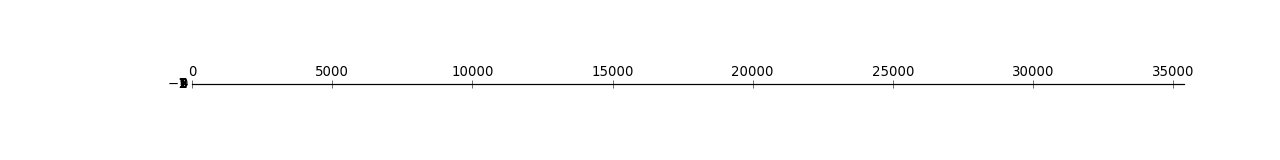

In [47]:
# Check these links:
# http://matplotlib.org/users/whats_new.html?highlight=heatmap
# http://discuss.analyticsvidhya.com/t/how-to-plot-heat-map-in-python/1922/2

__showed = plt.matshow(mat)
plt.show()

In [32]:
quant_file = "/usr/users/ga002/venturil/HPC_group-ga/Projects/Mikado/Arabidopsis/Alignments/Kallisto/Original/out_quant/abundance.tsv"

th_values = collections.defaultdict(dict)
with open(quant_file) as ab:
    for row in csv.DictReader(ab, delimiter="\t"):
        th_values[row["target_id"]]["tid"] = row["target_id"]
        th_values[row["target_id"]]["tpm"] = float(row["tpm"])

th_refmaps = ["Tophat/Mikado_compare/0.19/Class-compare.refmap",
"Tophat/Mikado_compare/0.19/Cufflinks-compare.refmap",
"Tophat/Mikado_compare/0.19/Stringtie-compare.refmap",
"Tophat/Mikado_compare/0.19/Trinity-compare.refmap",
"Tophat/Mikado_compare/0.19/ALL.combined.transcript-compare.refmap"]
th_refmaps = [os.path.join(
    "/usr/users/ga002/venturil/HPC_group-ga/Projects/Mikado/Arabidopsis/Assemblies", folder) for folder in refmaps]

th_labels = ["TH Class", "TH Cufflinks", "TH Stringtie", "TH Trinity", "TH ALL"]

for input_file, label in zip(th_refmaps, th_labels):
    th_values = analyse_refmap(input_file, label, th_values)

th_data = collections.defaultdict(list)
keys = None
for tid in th_values:
    if keys is None:
        keys = th_values[tid].keys()
    for key in th_values[tid]:
        th_data[key].append(th_values[tid][key])    
    
th_data = pandas.DataFrame(th_data, columns=["tid", "tpm"] + th_labels)
generate_plot(th_data, os.path.join(os.environ["HOME"], "Desktop", "expression.th.tiff"))